In [2]:
#import sys
#sys.path.insert(0, '../../..')
#from Practice.Utils.metrics import evaluate_classification
#from Practice.Utils.plots import plot_decision_boundary, plot_data
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from mlxtend.plotting import plot_decision_regions

In [43]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             r2_score)


def evaluate_regression(y_true, y_pred, use_log = False):
    """Evaluate regression model performance.

    Args:
        y_true (array): Ground truth values.
        y_pred (array): Predicted values.

    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    metrics = {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred, squared=False),
        'r2': r2_score(y_true, y_pred)
    }
    if use_log:
        metrics['msle'] = mean_squared_log_error(y_true, y_pred)
    return metrics

def evaluate_classification(y_true, y_pred, labels = None):
    """
    Evaluate classification model performance.

    Args:
        y_true (array): Ground truth values.
        y_pred (array): Predicted values.
        labels (list): List of labels to index the matrix.

    Returns:
        accuracy (float): Accuracy score.
        report (pd.DataFrame): Classification report.
        confusion_matrix (pd.DataFrame): Confusion matrix.
    """
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = pd.DataFrame(confusion_matrix(y_true, y_pred), labels, labels)
    return accuracy, report, confusion


import matplotlib.colors as mcolors
import torch



def plot_data(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)


def plot_decision_boundary(model, X, y):
    x_span = np.linspace(min(X[:, 0]) - 0.25, max(X[:, 0]) + 0.25, 50)
    y_span = np.linspace(min(X[:, 1]) - 0.25, max(X[:, 1]) + 0.25, 50)
    xx, yy = np.meshgrid(x_span, y_span)
    xx_, yy_ = xx.ravel(), yy.ravel()
    grid = np.c_[xx_, yy_]
    if hasattr(model, "predict_proba"):
        if hasattr(model, 'layer_activations') and model.layer_activations[-1] == 'sigmoid':
            pred_func = model.predict_proba(grid, False)[:,0]
        else:
            pred_func = model.predict_proba(grid)[:,0]
    else:
        # check if torch model
        if hasattr(model, "forward"):
            pred_func = 1 - model(torch.tensor(grid, dtype=torch.double)).detach().numpy()
        else:
            pred_func = 1 - model(grid).numpy()
    z = pred_func.reshape(xx.shape)
    c = plt.contourf(xx, yy, z, cmap="RdYlGn")
    plt.colorbar(c)
    colors = list(mcolors.TABLEAU_COLORS.keys())
    color_values = [colors[int(label)] for label in y]
    plt.scatter(X[:, 0], X[:, 1], marker="x", c=color_values)

In [19]:
class NeuralNet:
    def __init__(self, n_classes, layer_dims, layer_activations, mini_batch_size = 1, keep_prob=1, patience = 100, normalize = True, learning_rate = 0.01, num_epochs = 3000):
        self.n_classes = n_classes
        self.classes_ = np.array(range(n_classes))
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.normalize = normalize
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.keep_prob = keep_prob
        self.mini_batch_size = mini_batch_size

        self.best_loss = np.inf
        self.patience = patience
        self.epochs_without_improvement = 0

        self.is_cost_binary: bool
        if layer_activations[-1] == 'sigmoid':
            self.is_cost_binary = True
        else:
            self.is_cost_binary = False
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def transform(self, y_input):
        if self.layer_activations[-1]=='sigmoid':
            return y_input
        else:
            a_input = np.zeros((self.n_classes, y_input.shape[0]))
            for i in range(y_input.shape[0]):
                a_input[y_input[i][0]][i]=1
            return a_input.T

    def __softmax(self, Z):
        cache = Z
        A = np.exp(Z)/np.sum(np.exp(Z), axis=0, keepdims=True)
        return A, cache

    def __tanh(self, Z):
        A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
        cache = Z

        return A, cache

    def __relu(self, Z):
        A = np.maximum(0, Z)
        cache = Z

        assert(A.shape == Z.shape)

        return A, cache

    def __sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        cache = Z

        return A, cache
    
    def __softmax_backward(self, dA, cache):
        Z = cache
        
        exp_z = np.exp(Z)
        softmax_Z = exp_z / np.sum(exp_z, axis=1, keepdims=True)

        n = np.size(softmax_Z)
        tmp = np.tile(softmax_Z, n).reshape(n, n)
        dZ = np.dot(tmp * (np.identity(n) - np.transpose(tmp)), dA.reshape(-1))
        dZ = dZ.reshape(softmax_Z.shape)

        assert (dZ.shape == Z.shape)

        return dZ

    def __tanh_backward(self, dA, cache):
        Z = cache
        s = (1 - np.power(self.__tanh(Z)[0], 2))
        dZ = dA * s

        assert (dZ.shape == Z.shape)

        return dZ

    def __sigmoid_backward(self, dA, cache):
        Z = cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * (s * (1-s))

        assert (dZ.shape == Z.shape)

        return dZ
    
    def __relu_backward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

        assert (dZ.shape == Z.shape)
        
        return dZ
    
    def __linear_forward(self, A, W, b):
        Z = np.matmul(W, A) + b
        cache = (A, W, b)

        assert(Z.shape == (W.shape[0], A.shape[1]))

        return Z, cache

    def __initialize_parameters(self, layer_dims):
        np.random.seed(42)
        self.parameters={}
        self.grads={}

        L = len(layer_dims)
        for l in range(1, L):
            self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

            assert(self.parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
            assert(self.parameters['b' + str(l)].shape == (layer_dims[l], 1))
       
    def __linear_activation_forward(self, A_prev, W, b, activation, keep_prob=1):
        Z, linear_cache = self.__linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A, activation_cache = self.__sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = self.__relu(Z)
        elif activation == "tanh":
            A, activation_cache = self.__tanh(Z)
        elif activation == "softmax":
            A, activation_cache = self.__softmax(Z)

        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A * D
        A = A / keep_prob

        cache = (linear_cache, activation_cache, D)

        assert (A.shape == (W.shape[0], A_prev.shape[1]))

        return A, cache
       
    def __forward_propagation(self, X, parameters=None, keep_prob=1):
        caches = []
        A = X
        L = len(parameters) // 2

        for l in range(1, L):
            A_prev = A
            A, cache = self.__linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = self.layer_activations[l - 1], keep_prob=keep_prob)
            caches.append(cache)
        
        AL, cache = self.__linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = self.layer_activations[L - 1])
        caches.append(cache)


        return AL, caches
    
    def compute_cost_binary(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def compute_cost_multi_class(self, A, Y):
        m = Y.shape[1]
        epsilon = 1e-8
        res = Y * np.log(A + epsilon)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    

    def __linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.matmul(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.matmul(W.T,dZ)

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)
    
        return dA_prev, dW, db
        
    def __linear_activation_backward(self, dA, Y, cache, activation, keep_prob=1):
        linear_cache, activation_cache, D = cache
        dA = dA * D
        dA = dA / keep_prob
        if activation == "relu":
            dZ = self.__relu_backward(dA, activation_cache)
        elif activation == "sigmoid":
            dZ = self.__sigmoid_backward(dA, activation_cache)
        elif activation == "softmax":
            dZ = self.__softmax_backward(dA, activation_cache)
        elif activation == "tanh":
            dZ = self.__tanh_backward(dA, activation_cache)

        dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    
        return dA_prev, dW, db
    

    def __linear_activation_backward_last(self, dA, Y, cache, activation, keep_prob=1):
        linear_cache, activation_cache, D = cache
        dA = dA * D
        dA = dA / keep_prob
        dZ = dA
        dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    
        return dA_prev, dW, db

    def __backward_propagation(self, AL, Y, caches, keep_prob=1):
        L = len(caches)
        m = AL.shape[1]
        if self.is_cost_binary:
            dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
            current_cache = caches[L-1]
            self.grads["dA" + str(L-1)], self.grads["dW" + str(L)], self.grads["db" + str(L)] = self.__linear_activation_backward(dAL, Y, current_cache, activation = self.layer_activations[L - 1])
        else:
            dAL = AL - Y
            current_cache = caches[L-1]
            self.grads["dA" + str(L-1)], self.grads["dW" + str(L)], self.grads["db" + str(L)] = self.__linear_activation_backward_last(dAL, Y, current_cache, activation = self.layer_activations[L - 1])



        
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__linear_activation_backward(self.grads["dA" + str(l + 1)], Y, current_cache, activation = self.layer_activations[l], keep_prob=keep_prob)
            self.grads["dA" + str(l)] = dA_prev_temp
            self.grads["dW" + str(l + 1)] = dW_temp
            self.grads["db" + str(l + 1)] = db_temp
    
    def __update_parameters(self):
        L = len(self.parameters) // 2

        for l in range(L):
            self.parameters["W" + str(l+1)] = self.parameters["W" + str(l+1)] - self.learning_rate * self.grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] = self.parameters["b" + str(l+1)] - self.learning_rate * self.grads["db" + str(l+1)]

    def __random_mini_batches(self, X, Y, mini_batch_size=1, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        if self.layer_activations[-1]=='sigmoid':
            shuffled_Y = Y[:, permutation].reshape((1,m))
        else:
            shuffled_Y = Y[:, permutation]

        num_complete_minibatches = math.floor(m / mini_batch_size)

        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, mini_batch_size * k : mini_batch_size * (k + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * k : mini_batch_size * (k + 1)]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        return mini_batches
      
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X= X_vert.T
        Y = (self.transform(Y_vert)).T
        X_test = X_vert.T
        Y_test = (self.transform(Y_vert)).T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        self.__initialize_parameters(self.layer_dims)
        m = X.shape[1]
        seed = 0
        minibatch_size = self.mini_batch_size

        if self.is_cost_binary:
            cost_function = self.compute_cost_binary
        else:
            cost_function = self.compute_cost_multi_class

        for i in range(self.num_epochs + 1):

            seed = seed + 1
            minibatches = self.__random_mini_batches(X, Y, minibatch_size, seed)
            cost_total = 0
            val_cost_total = 0

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                AL, caches = self.__forward_propagation(minibatch_X, self.parameters, self.keep_prob)

                cost_total += cost_function(AL, minibatch_Y)

                self.__backward_propagation(AL, minibatch_Y, caches, self.keep_prob)

                #self.__gradient_check(self.parameters, self.grads, AL, minibatch_X, minibatch_Y, cost_function)

                self.__update_parameters()

            AL_test, _ = self.__forward_propagation(X_test, self.parameters, self.keep_prob)
            val_cost_total += cost_function(AL_test, Y_test)

            cost_avg = cost_total / m
            val_cost_avg = val_cost_total

            if val_cost_avg < self.best_loss:
                self.best_loss = val_cost_avg
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

            if self.epochs_without_improvement >= self.patience:
                print(f"Early stopping after {i} epochs.")
                break

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost_avg))

            if i % 100 == 0:
                costs.append(cost_avg)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
     
    
    def predict_proba(self, X_vert, bool=True):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
    
        probs, _ = self.__forward_propagation(X, self.parameters)
        if self.layer_activations[-1] == 'sigmoid':
            if not bool:
                return np.column_stack((1 - probs.T, probs.T))
            result = np.column_stack((1 - probs.T, probs.T))[:, 1].T
        elif self.layer_activations[-1] == 'softmax':
            result = probs.T
        else:
            raise ValueError("Unsupported activation function in the last layer")
    
        return result

    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        if (self.layer_activations[-1] == 'sigmoid'):
            result = (positive_probs >= 0.5).astype(int)
        elif self.layer_activations[-1] == 'softmax':
            result = np.argmax(positive_probs, axis=1).reshape(-1, 1)
        else:
            raise ValueError("Unsupported activation function in the last layer")
        return result


# Симульовані дані 1

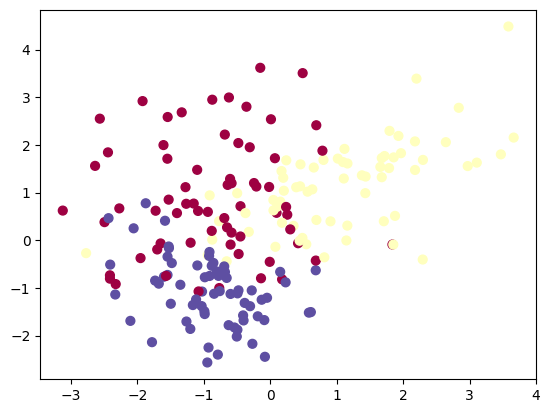

0-th iteration: 0.5684424278963063
1000-th iteration: 0.28394533795572896
2000-th iteration: 0.2540395369922861
3000-th iteration: 0.2401696460507723
Early stopping after 3476 epochs.


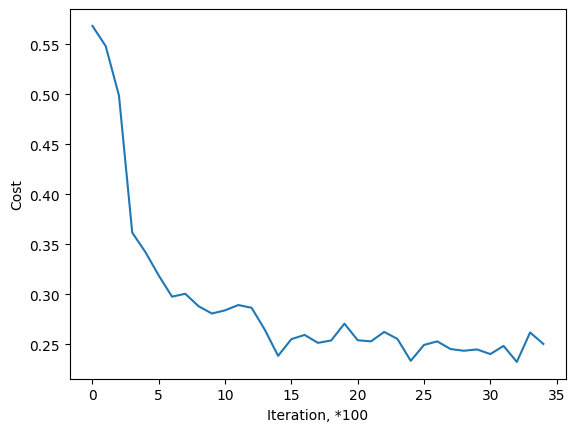

Accuracy: 
0.95
Report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       1.00      0.94      0.97        16
           2       0.92      1.00      0.96        12

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

Confusion: 
    0   1   2
0  11   0   1
1   1  15   0
2   0   0  12


Text(0, 0.5, 'x2')

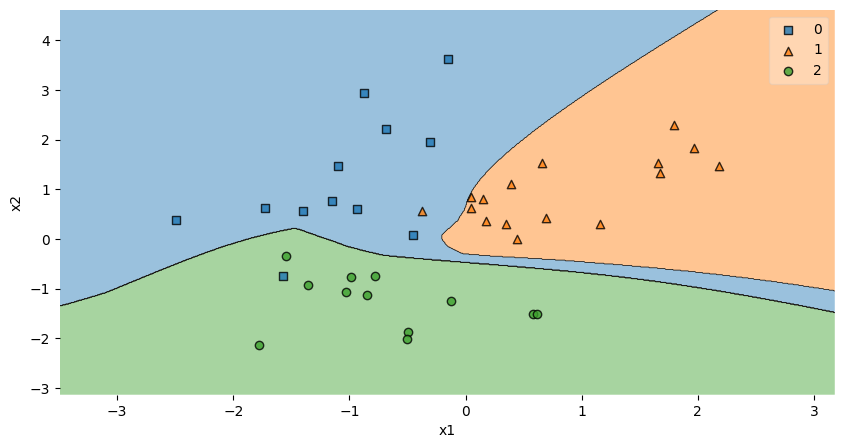

In [26]:
X, y = make_classification(n_samples = 200, n_classes = 3, n_features = 2, 
                            n_informative=2, n_redundant=0, random_state = 42,
                            flip_y=0.02, class_sep=1,  n_clusters_per_class=1)
plot_data(X, y)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size=0.2, random_state=42)
layer_dims_1 = [X.shape[1], 20, 20, 20, 20, 20, 3]
layer_activations_1 = ['tanh', 'sigmoid', 'relu', 'sigmoid', 'relu', 'softmax']
batch_size_1 = 2
keep_prob_1 = 0.95
patience_1 = 1000

nn = NeuralNet(3, layer_dims_1, layer_activations_1, mini_batch_size=batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.001, num_epochs=5000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)
accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")

fig = plt.figure(figsize=(10,5))
fig = plot_decision_regions(X=X_test, y=np.ndarray.flatten(y_test), clf=nn)
plt.xlabel('x1')
plt.ylabel('x2')

# Симульовані дані 2

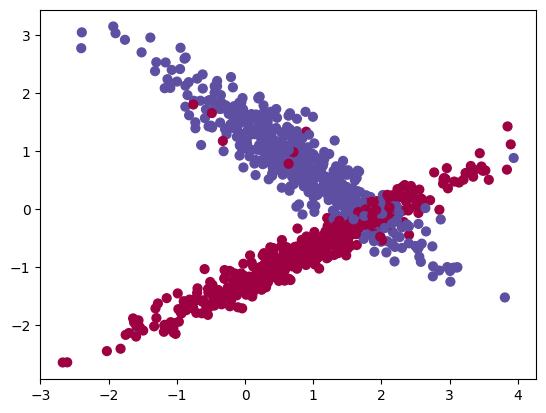

0-th iteration: 0.022665751913495936
1000-th iteration: 0.006229743609814545
2000-th iteration: 0.005035298969082295
3000-th iteration: 0.00528619985972404
Early stopping after 3066 epochs.


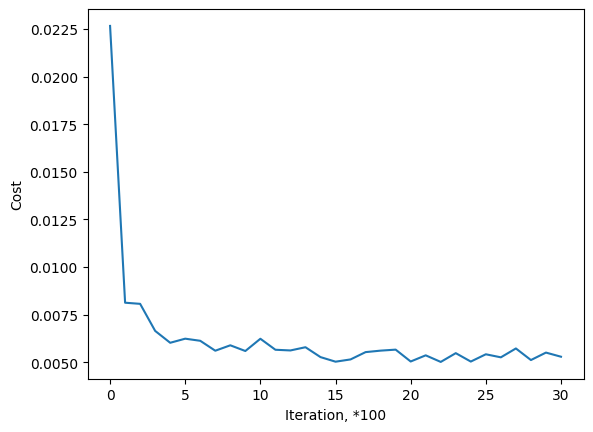

Accuracy: 
0.92
Report: 
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       101
           1       0.90      0.95      0.92        99

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

Confusion: 
    0   1
0  90  11
1   5  94


C:\Users\Ректор\AppData\Local\Temp\ipykernel_12124\2935973057.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


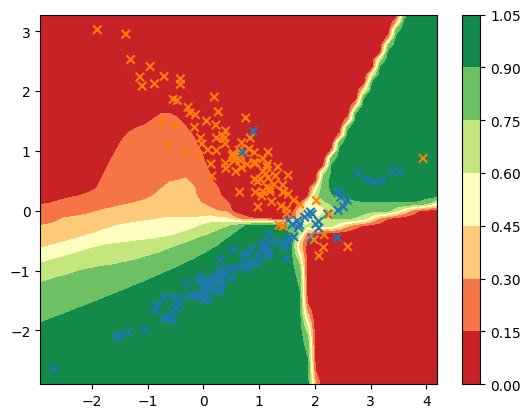

In [28]:
NUM_CLASSES = 2
X, y = make_classification(n_samples = 1000, n_classes = NUM_CLASSES, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8, n_clusters_per_class=1)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_dims_1 = [X.shape[1], 20, 20, 20, 20, 20, 1]
layer_activations_1 = ['relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_1 = 32
keep_prob_1 = 0.9
patience_1 = 3000

nn = NeuralNet(NUM_CLASSES, layer_dims_1, layer_activations_1, mini_batch_size=mini_batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.01, num_epochs=5000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 3

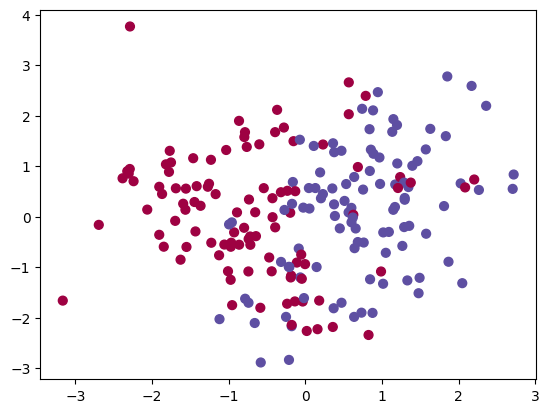

0-th iteration: 0.3737254631683761
1000-th iteration: 0.19756537703287302
2000-th iteration: 0.18776537464285872
3000-th iteration: 0.1931107354160925
4000-th iteration: 0.18228979214292088
Early stopping after 4423 epochs.


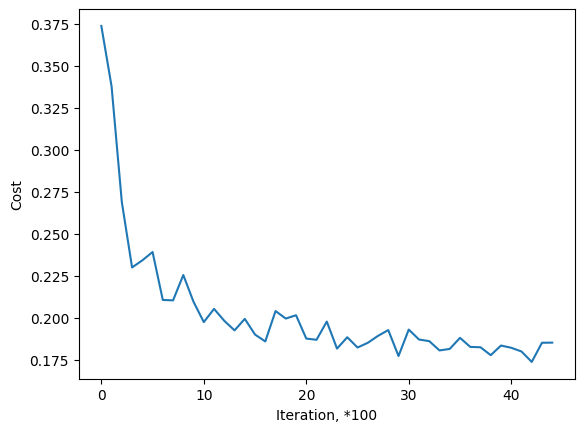

Accuracy: 
0.775
Report: 
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.71      0.83      0.77        18

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.78        40

Confusion: 
    0   1
0  16   6
1   3  15


C:\Users\Ректор\AppData\Local\Temp\ipykernel_12124\2935973057.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


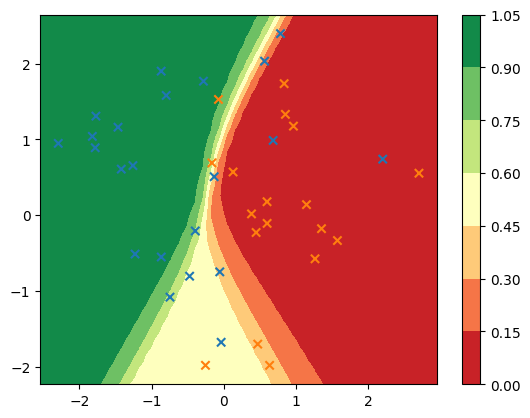

In [29]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size=0.2, random_state=42)
layer_dims_1 = [X.shape[1], 20, 20, 20, 20, 20, 2]
layer_activations_1 = ['tanh', 'sigmoid', 'relu', 'sigmoid', 'relu', 'softmax']
batch_size_1 = 2
keep_prob_1 = 0.95
patience_1 = 1000

nn = NeuralNet(2, layer_dims_1, layer_activations_1, mini_batch_size=batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.001, num_epochs=5000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()


# Симульовані дані 4

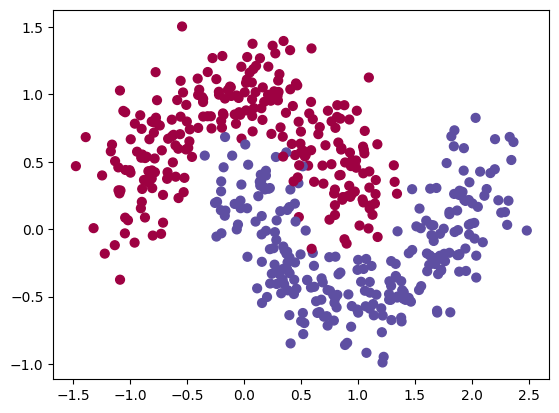

0-th iteration: 0.36401808994707524
1000-th iteration: 0.05586716787775339
Early stopping after 1239 epochs.


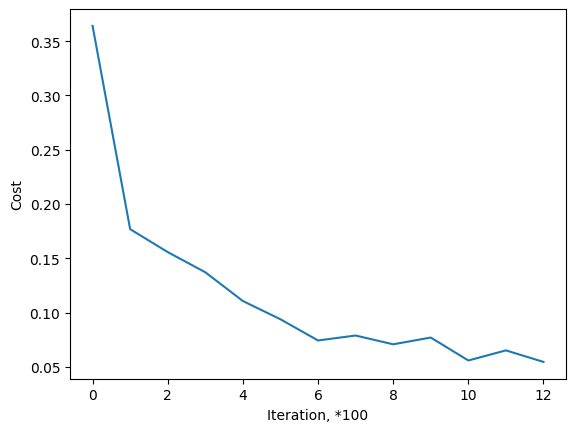

Accuracy: 
0.97
Report: 
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        43
           1       1.00      0.95      0.97        57

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

Confusion: 
    0   1
0  43   0
1   3  54


C:\Users\Ректор\AppData\Local\Temp\ipykernel_12124\2935973057.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


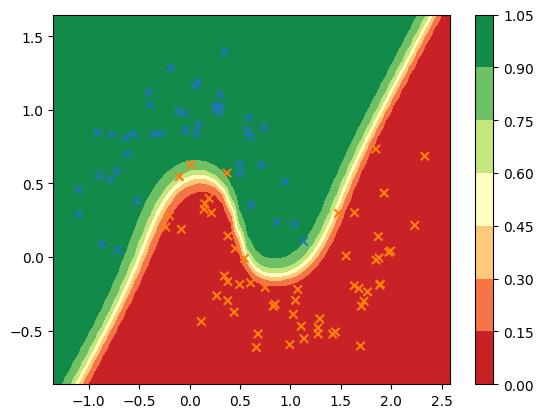

In [30]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

plot_data(X, y)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size=0.2, random_state=42)
layer_dims_1 = [X.shape[1], 20, 20, 20, 20, 20, 2]
layer_activations_1 = ['tanh', 'sigmoid', 'relu', 'sigmoid', 'relu', 'softmax']
batch_size_1 = 2
keep_prob_1 = 0.95
patience_1 = 1000

nn = NeuralNet(2, layer_dims_1, layer_activations_1, mini_batch_size=batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.001, num_epochs=5000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

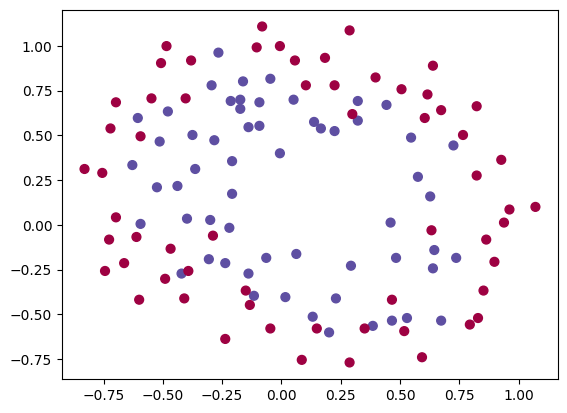

In [39]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

0-th iteration: 0.7191508405740624
1000-th iteration: 0.26056471745365706
2000-th iteration: 0.22723252016719456
Early stopping after 2052 epochs.


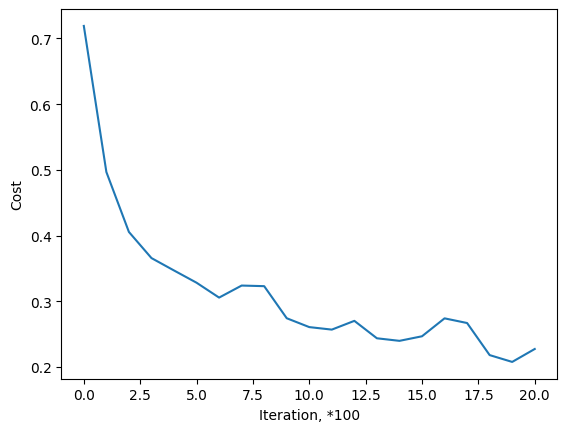

Accuracy: 
0.7916666666666666
Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

Confusion: 
    0  1
0  10  2
1   3  9


C:\Users\Ректор\AppData\Local\Temp\ipykernel_12124\4050293051.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


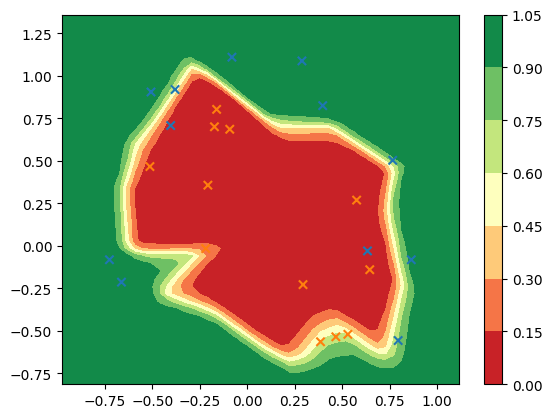

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size=0.2, random_state=42)
layer_dims_1 = [X.shape[1], 30, 50, 100, 2]
layer_activations_1 = ['relu', 'tanh', 'relu',  'softmax']
batch_size_1 = 1
keep_prob_1 = 0.97
patience_1 = 2000

nn = NeuralNet(2, layer_dims_1, layer_activations_1, mini_batch_size=batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.001, num_epochs=5000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [44]:
print(nn.parameters)

{'W1': array([[ 0.35798355, -0.17417328],
       [ 0.46642494,  0.82580381],
       [-0.48030266, -0.44610835],
       [ 1.35185169,  0.4593968 ],
       [-0.34772767,  0.40925816],
       [-0.37628717, -0.27359333],
       [ 0.19250052, -1.38815775],
       [-1.22702917, -0.36910018],
       [-0.61019419,  0.23543572],
       [-0.57406688, -0.4385016 ],
       [ 0.93845236, -0.03399836],
       [ 0.06667871, -0.93690476],
       [-0.39812022,  0.26681791],
       [-0.51428736, -0.01967239],
       [-0.32698694, -0.28392733],
       [-0.39162256,  1.12906808],
       [-0.07026749, -0.77733012],
       [ 0.61756553, -0.79220739],
       [ 0.19145079, -1.15308751],
       [-0.87527473, -0.09053418]]), 'b1': array([[-0.17380897],
       [ 0.71111312],
       [ 0.67413099],
       [-0.07345033],
       [ 0.47953794],
       [ 0.16473678],
       [-0.26132491],
       [-0.09049902],
       [-0.630433  ],
       [-0.44327446],
       [ 0.10153104],
       [-0.36883944],
       [ 0.41262649],

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

Accuracy: 
0.7916666666666666
Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

Confusion: 
    0  1
0  10  2
1   3  9


C:\Users\Ректор\AppData\Local\Temp\ipykernel_12124\4050293051.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


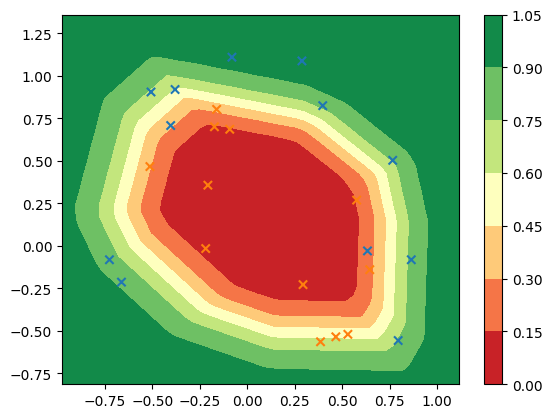

In [45]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(clf, X_test, y_test)
plt.show()

In [46]:
clf.n_iter_

1444